# Adaptive Thermal-RGB Pairing Strategy
處理不固定 FPS 和資料遺漏問題

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
import re
import time
import random

print("Libraries loaded")
print(f"CPU cores: {cpu_count()}")

Libraries loaded
CPU cores: 4


In [2]:
DATA_DIR = Path('./data')
THERMAL_DIR = DATA_DIR / 'thermal'
CAMERA_DIR = DATA_DIR / 'camera'
AVI_FILE = CAMERA_DIR / 'output.avi'
OUTPUT_TXT = CAMERA_DIR / 'output.txt'

OUTPUT_DIR = Path('./output')
ROBUST_DIR = OUTPUT_DIR / 'adaptive_pairing'
ROBUST_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output: {ROBUST_DIR}")

Output: output/adaptive_pairing


In [3]:
def parse_output_txt(filepath):
    if not filepath.exists():
        return None
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    patterns = [
        (r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y-%m-%d %H:%M:%S'),
        (r'(\d{4}/\d{2}/\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y/%m/%d %H:%M:%S'),
    ]
    for pattern, fmt in patterns:
        match = re.search(pattern, content)
        if match:
            try:
                return datetime.strptime(match.group(1), fmt)
            except:
                continue
    return None

camera_start_time = parse_output_txt(OUTPUT_TXT)
print(f"Camera start: {camera_start_time}")

Camera start: 2020-09-24 13:09:29


In [4]:
def parse_thermal_file(file_path):
    data = []
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    data_dict = json.loads(line)
                    time_parts = data_dict.get('time', [])
                    if len(time_parts) < 6:
                        continue
                    year, month, day, hour, minute, second = time_parts[:6]
                    millisecond = time_parts[7] if len(time_parts) > 7 else 0
                    timestamp = datetime(year, month, day, hour, minute, second, millisecond * 1000)
                    message = data_dict.get('message', [])
                    if len(message) != 768:
                        continue
                    thermal_image = np.array(message, dtype=np.uint8).reshape(24, 32)
                    data.append({'timestamp': timestamp, 'image': thermal_image})
                except:
                    continue
    except Exception as e:
        print(f"Error: {e}")
    return data

print("Loading thermal...")
log_files = sorted(THERMAL_DIR.glob('log*.txt'))
print(f"Found {len(log_files)} files")

therm_data = []
with ProcessPoolExecutor(max_workers=3) as executor:
    results = list(tqdm(executor.map(parse_thermal_file, log_files), total=len(log_files), desc="Loading"))
    for file_data in results:
        therm_data.extend(file_data)

therm_data.sort(key=lambda x: x['timestamp'])
print(f"Loaded {len(therm_data)} thermal frames")

Loading thermal...
Found 5 files


Loading: 100%|██████████| 5/5 [00:00<00:00, 22.48it/s]

Loaded 5318 thermal frames


In [5]:
cap = cv2.VideoCapture(str(AVI_FILE))
if cap.isOpened():
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    cap.release()
    print(f"AVI: {frame_count} frames @ {fps}fps, duration: {duration:.2f}s")
else:
    print("Error opening AVI")
    fps, frame_count, duration = 0, 0, 0

AVI: 16284 frames @ 24.67fps, duration: 660.07s


In [6]:
def analyze_thermal_distribution(thermal_data, camera_start_time):
    sections = {}
    
    for frame in thermal_data:
        offset = (frame['timestamp'] - camera_start_time).total_seconds()
        if offset < 0:
            continue
        
        second = int(offset)
        if second not in sections:
            sections[second] = []
        sections[second].append(frame)
    
    print("\n" + "="*70)
    print("Thermal Frame Distribution Analysis")
    print("="*70)
    
    section_counts = {sec: len(frames) for sec, frames in sections.items()}
    counts = list(section_counts.values())
    
    print(f"\nTotal sections: {len(sections)}")
    print(f"Min frames/sec: {min(counts)}")
    print(f"Max frames/sec: {max(counts)}")
    print(f"Mean frames/sec: {np.mean(counts):.1f}")
    print(f"Std frames/sec: {np.std(counts):.1f}")
    
    burst_seconds = {sec: (count, count - 8) for sec, count in section_counts.items() if count > 8}
    dropout_seconds = [sec for sec, count in section_counts.items() if count < 8]
    normal_seconds = [sec for sec, count in section_counts.items() if count == 8]
    
    print(f"\nNormal (8 frames): {len(normal_seconds)} seconds")
    print(f"Dropout (< 8 frames): {len(dropout_seconds)} seconds")
    print(f"Burst (> 8 frames): {len(burst_seconds)} seconds")
    
    return sections

sections = analyze_thermal_distribution(therm_data, camera_start_time)


Thermal Frame Distribution Analysis

Total sections: 677
Min frames/sec: 5
Max frames/sec: 57
Mean frames/sec: 7.9
Std frames/sec: 2.0

Normal (8 frames): 462 seconds
Dropout (< 8 frames): 178 seconds
Burst (> 8 frames): 37 seconds


In [7]:
def adaptive_thermal_rgb_pairing(thermal_data, camera_start_time, fps, frame_count, sections):
    print("\n" + "="*70)
    print("Adaptive Thermal-RGB Pairing")
    print("="*70)
    
    burst_seconds = {}
    dropout_seconds = []
    
    for sec in sorted(sections.keys()):
        count = len(sections[sec])
        if count > 8:
            burst_seconds[sec] = count - 8
        elif count < 8:
            dropout_seconds.append(sec)
    
    print(f"\n1. Redistribution Strategy:")
    print(f"   Burst seconds: {len(burst_seconds)}")
    print(f"   Dropout seconds: {len(dropout_seconds)}")
    
    excess_frames = []
    for sec in sorted(burst_seconds.keys()):
        frames = sections[sec]
        for frame in frames[8:]:
            excess_frames.append((frame, sec))
    
    print(f"\n2. Excess Frames Collection:")
    print(f"   Total excess frames: {len(excess_frames)}")
    
    excess_idx = 0
    redistribution_log = []
    
    for dropout_sec in sorted(dropout_seconds):
        missing_count = 8 - len(sections[dropout_sec])
        
        if excess_idx < len(excess_frames):
            frames_to_add = min(missing_count, len(excess_frames) - excess_idx)
            
            for i in range(frames_to_add):
                frame, original_sec = excess_frames[excess_idx]
                sections[dropout_sec].append(frame)
                redistribution_log.append({
                    'from_sec': original_sec,
                    'to_sec': dropout_sec,
                    'frame': frame
                })
                excess_idx += 1
    
    print(f"   Redistributed frames: {len(redistribution_log)}")
    
    pairs = []
    rgb_end_time = camera_start_time + timedelta(seconds=frame_count/fps)
    
    for sec in sorted(sections.keys()):
        for thermal_frame in sections[sec]:
            thermal_ts = thermal_frame['timestamp']
            
            if thermal_ts < camera_start_time or thermal_ts > rgb_end_time:
                continue
            
            offset = (thermal_ts - camera_start_time).total_seconds()
            rgb_frame_idx = int(round(offset * fps))
            rgb_frame_idx = max(0, min(rgb_frame_idx, frame_count - 1))
            
            actual_time = rgb_frame_idx / fps
            rgb_error = abs(actual_time - offset)
            
            pairs.append({
                'pair_id': f'pair_{len(pairs):05d}',
                'thermal': thermal_frame,
                'rgb_frame_idx': rgb_frame_idx,
                'timestamp': thermal_ts,
                'section': sec,
                'rgb_error': rgb_error
            })
    
    print(f"\n3. Final Pairing Results:")
    print(f"   Total pairs: {len(pairs)}")
    print(f"   Success rate: {len(pairs) / len(thermal_data) * 100:.1f}%")
    
    if len(pairs) > 0:
        rgb_errors = [p['rgb_error'] * 1000 for p in pairs]
        print(f"\n   RGB Error Statistics:")
        print(f"   Mean: {np.mean(rgb_errors):.2f}ms")
        print(f"   Median: {np.median(rgb_errors):.2f}ms")
        print(f"   Max: {np.max(rgb_errors):.2f}ms")
        print(f"   Std: {np.std(rgb_errors):.2f}ms")
    
    return pairs, redistribution_log

pairs_adaptive, redistribution_log = adaptive_thermal_rgb_pairing(
    therm_data, camera_start_time, fps, frame_count, sections
)


Adaptive Thermal-RGB Pairing

1. Redistribution Strategy:
   Burst seconds: 37
   Dropout seconds: 178

2. Excess Frames Collection:
   Total excess frames: 85
   Redistributed frames: 85

3. Final Pairing Results:
   Total pairs: 5168
   Success rate: 97.2%

   RGB Error Statistics:
   Mean: 10.09ms
   Median: 10.20ms
   Max: 20.20ms
   Std: 5.86ms


In [8]:
# 驗證配對品質
print("\n" + "="*70)
print("Validation & Statistics")
print("="*70)

section_pairs = {}
for pair in pairs_adaptive:
    sec = pair['section']
    if sec not in section_pairs:
        section_pairs[sec] = 0
    section_pairs[sec] += 1

print(f"\nPairs per Section Distribution:")
pair_counts = list(section_pairs.values())
print(f"  Mean: {np.mean(pair_counts):.1f}")
print(f"  Min: {min(pair_counts)}")
print(f"  Max: {max(pair_counts)}")
print(f"  Sections with pairs: {len(section_pairs)}")

rgb_errors = [p['rgb_error'] * 1000 for p in pairs_adaptive]
print(f"\nRGB Time Alignment:")
print(f"  Pairs with error < 20ms: {sum(1 for e in rgb_errors if e < 20)} ({sum(1 for e in rgb_errors if e < 20)/len(rgb_errors)*100:.1f}%)")
print(f"  Pairs with error < 40ms: {sum(1 for e in rgb_errors if e < 40)} ({sum(1 for e in rgb_errors if e < 40)/len(rgb_errors)*100:.1f}%)")
print(f"  Pairs with error > 100ms: {sum(1 for e in rgb_errors if e > 100)} ({sum(1 for e in rgb_errors if e > 100)/len(rgb_errors)*100:.1f}%)")


Validation & Statistics

Pairs per Section Distribution:
  Mean: 7.8
  Min: 7
  Max: 9
  Sections with pairs: 659

RGB Time Alignment:
  Pairs with error < 20ms: 5120 (99.1%)
  Pairs with error < 40ms: 5168 (100.0%)
  Pairs with error > 100ms: 0 (0.0%)


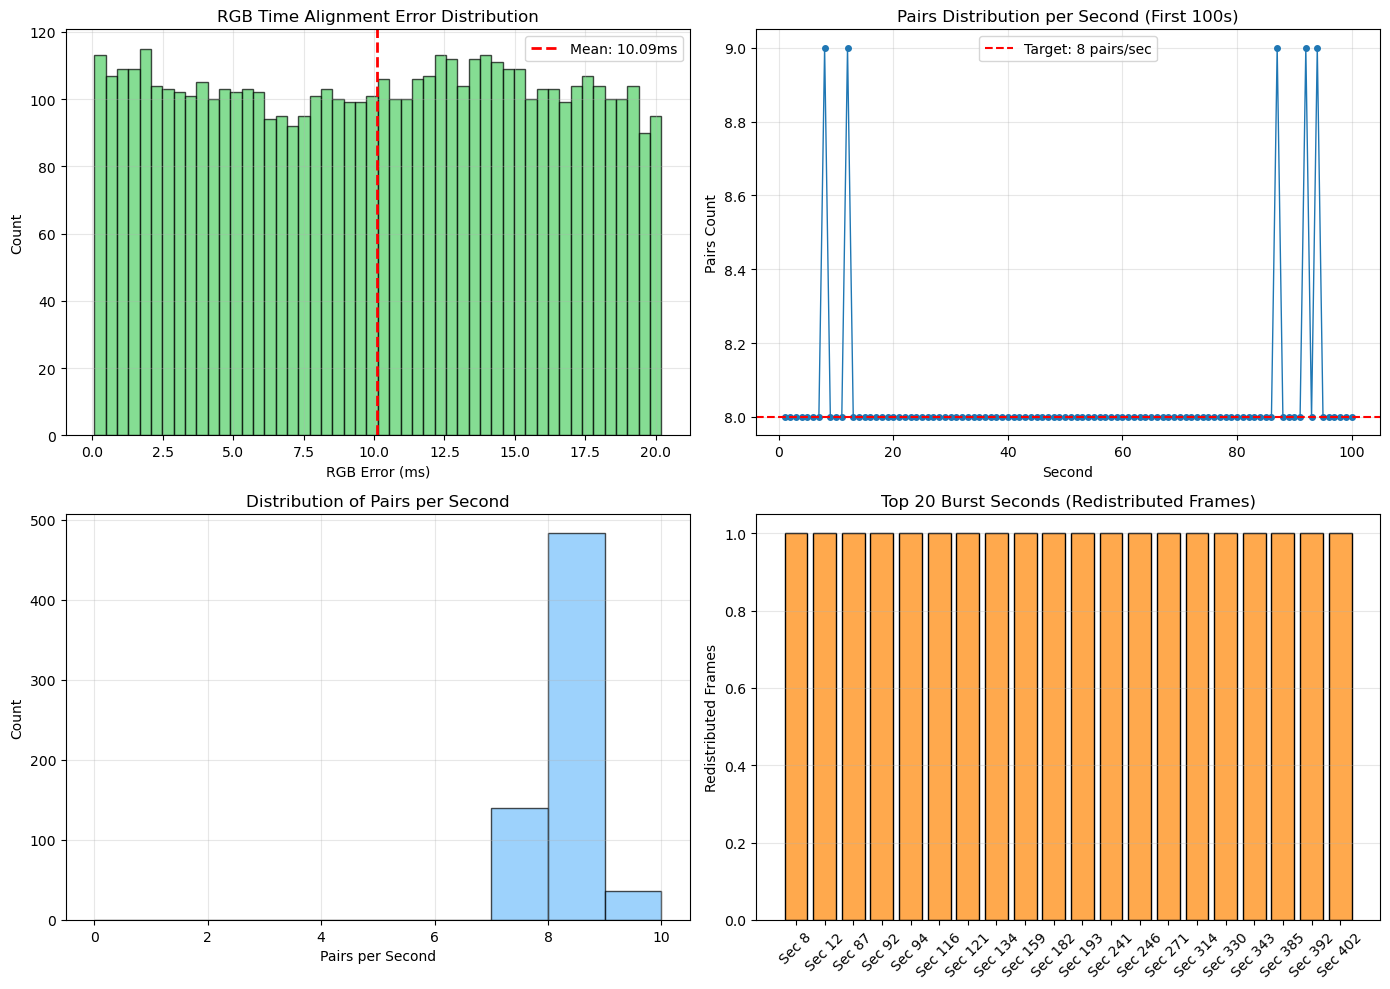


Visualization saved to: output/adaptive_pairing/adaptive_pairing_analysis.png


In [9]:
# 可視化結果
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. RGB 誤差分布
axes[0, 0].hist(rgb_errors, bins=50, edgecolor='black', alpha=0.7, color='#51cf66')
axes[0, 0].axvline(np.mean(rgb_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(rgb_errors):.2f}ms')
axes[0, 0].set_xlabel('RGB Error (ms)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('RGB Time Alignment Error Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 每秒配對數
secs = sorted(section_pairs.keys())
counts = [section_pairs[sec] for sec in secs]
axes[0, 1].plot(secs[:100], counts[:100], marker='o', markersize=4, linewidth=1)
axes[0, 1].axhline(8, color='red', linestyle='--', label='Target: 8 pairs/sec')
axes[0, 1].set_xlabel('Second')
axes[0, 1].set_ylabel('Pairs Count')
axes[0, 1].set_title('Pairs Distribution per Second (First 100s)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 配對計數直方圖
axes[1, 0].hist(pair_counts, bins=range(0, max(pair_counts)+2), edgecolor='black', alpha=0.7, color='#74c0fc')
axes[1, 0].set_xlabel('Pairs per Second')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Pairs per Second')
axes[1, 0].grid(True, alpha=0.3)

# 4. 重新分配統計
if redistribution_log:
    redistribution_from = {}
    for log in redistribution_log:
        if log['from_sec'] not in redistribution_from:
            redistribution_from[log['from_sec']] = 0
        redistribution_from[log['from_sec']] += 1
    
    from_secs = sorted(redistribution_from.keys())[:20]
    from_counts = [redistribution_from[sec] for sec in from_secs]
    axes[1, 1].bar(range(len(from_secs)), from_counts, color='#ffa94d', edgecolor='black')
    axes[1, 1].set_xticks(range(len(from_secs)))
    axes[1, 1].set_xticklabels([f"Sec {sec}" for sec in from_secs], rotation=45)
    axes[1, 1].set_ylabel('Redistributed Frames')
    axes[1, 1].set_title('Top 20 Burst Seconds (Redistributed Frames)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, 'No Redistribution Needed', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Redistribution Log')

plt.tight_layout()
plt.savefig(ROBUST_DIR / 'adaptive_pairing_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", ROBUST_DIR / 'adaptive_pairing_analysis.png')

In [10]:
# 保存配對結果 + 標籤
cap = cv2.VideoCapture(str(AVI_FILE))

pairs_export = []
for pair in pairs_adaptive:
    pairs_export.append({
        'pair_id': pair['pair_id'],
        'rgb_frame_idx': pair['rgb_frame_idx'],
        'timestamp': pair['timestamp'].isoformat(),
        'section': pair['section'],
        'rgb_error_ms': pair['rgb_error'] * 1000,
        'label': 'thermal',  # 標籤
        'modality': 'thermal-rgb'
    })

# 保存為 JSON
with open(ROBUST_DIR / 'pairs_mapping.json', 'w') as f:
    json.dump(pairs_export, f, indent=2)

# 保存為 CSV
df_pairs = pd.DataFrame(pairs_export)
df_pairs.to_csv(ROBUST_DIR / 'pairs_mapping.csv', index=False)

print(f"Pairs exported:")
print(f"  - JSON: {ROBUST_DIR / 'pairs_mapping.json'}")
print(f"  - CSV: {ROBUST_DIR / 'pairs_mapping.csv'}")
print(f"\nTotal pairs: {len(pairs_export)}")

cap.release()

Pairs exported:
  - JSON: output/adaptive_pairing/pairs_mapping.json
  - CSV: output/adaptive_pairing/pairs_mapping.csv

Total pairs: 5168



Random Sampling Verification


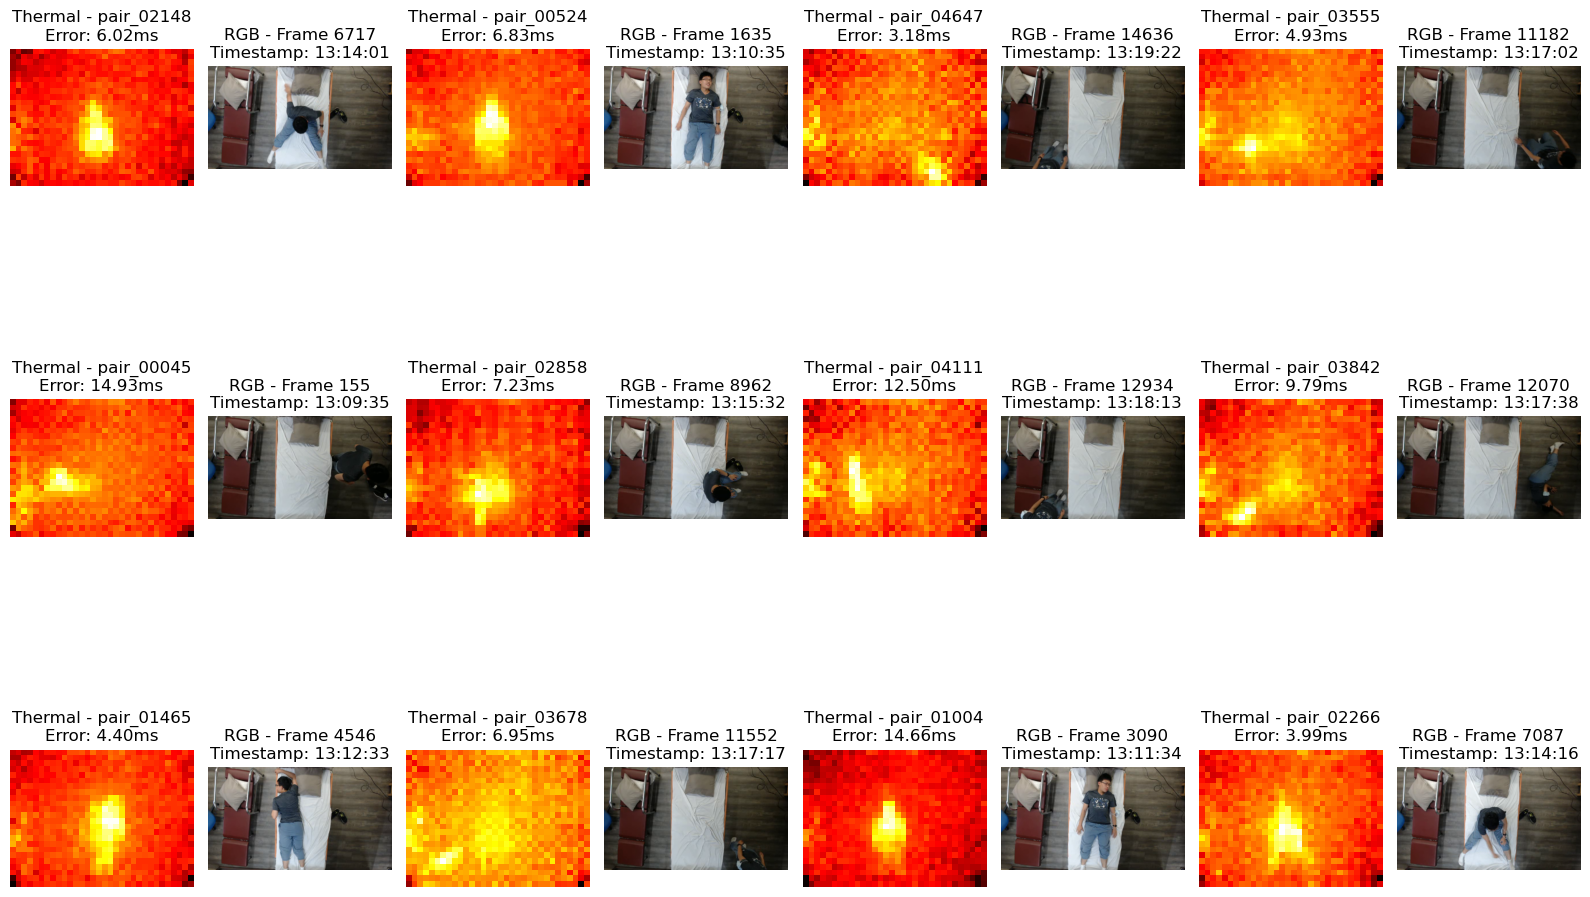


Sample verification images saved to: output/adaptive_pairing/random_sample_verification.png


In [11]:
# 隨機抽查驗證 - 視覺化配對
print("\n" + "="*70)
print("Random Sampling Verification")
print("="*70)

# 隨機抽取 12 對進行檢查
sample_size = min(12, len(pairs_adaptive))
sample_indices = random.sample(range(len(pairs_adaptive)), sample_size)
sample_pairs = [pairs_adaptive[i] for i in sample_indices]

# 讀取 AVI
cap = cv2.VideoCapture(str(AVI_FILE))

# 創建子圖
n_cols = 4
n_rows = (sample_size + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, (sample_pair, ax_idx) in enumerate(zip(sample_pairs, range(0, len(axes), 2))):
    # 取得熱像儀圖
    thermal_img = sample_pair['thermal']['image']
    
    # 取得 RGB 幀
    rgb_frame_idx = sample_pair['rgb_frame_idx']
    cap.set(cv2.CAP_PROP_POS_FRAMES, rgb_frame_idx)
    ret, rgb_frame = cap.read()
    
    if not ret:
        continue
    
    # 顯示熱像儀圖
    axes[ax_idx].imshow(thermal_img, cmap='hot')
    axes[ax_idx].set_title(f"Thermal - {sample_pair['pair_id']}\nError: {sample_pair['rgb_error']*1000:.2f}ms")
    axes[ax_idx].axis('off')
    
    # 顯示 RGB 幀
    rgb_frame_rgb = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2RGB)
    axes[ax_idx + 1].imshow(rgb_frame_rgb)
    axes[ax_idx + 1].set_title(f"RGB - Frame {rgb_frame_idx}\nTimestamp: {sample_pair['timestamp'].strftime('%H:%M:%S')}")
    axes[ax_idx + 1].axis('off')

# 隱藏多餘的子圖
for ax in axes[len(axes) - (len(axes) % 2):] if len(axes) % 2 != 0 else []:
    ax.axis('off')

plt.tight_layout()
plt.savefig(ROBUST_DIR / 'random_sample_verification.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nSample verification images saved to: {ROBUST_DIR / 'random_sample_verification.png'}")
cap.release()

In [12]:
# 詳細的隨機抽查報告
print("\n" + "="*70)
print("DETAILED RANDOM SAMPLING REPORT")
print("="*70)

for idx, sample_pair in enumerate(sample_pairs, 1):
    print(f"\n[Sample {idx}/{len(sample_pairs)}]")
    print(f"  Pair ID: {sample_pair['pair_id']}")
    print(f"  Thermal Timestamp: {sample_pair['timestamp'].strftime('%H:%M:%S.%f')[:-3]}")
    print(f"  RGB Frame Index: {sample_pair['rgb_frame_idx']}")
    print(f"  RGB Error: {sample_pair['rgb_error']*1000:.2f}ms")
    print(f"  Section: {sample_pair['section']}")
    print(f"  Status: ✓ OK" if sample_pair['rgb_error']*1000 < 20 else f"  Status: ⚠ WARNING")


DETAILED RANDOM SAMPLING REPORT

[Sample 1/12]
  Pair ID: pair_02148
  Thermal Timestamp: 13:14:01.268
  RGB Frame Index: 6717
  RGB Error: 6.02ms
  Section: 272
  Status: ✓ OK

[Sample 2/12]
  Pair ID: pair_00524
  Thermal Timestamp: 13:10:35.268
  RGB Frame Index: 1635
  RGB Error: 6.83ms
  Section: 66
  Status: ✓ OK

[Sample 3/12]
  Pair ID: pair_04647
  Thermal Timestamp: 13:19:22.268
  RGB Frame Index: 14636
  RGB Error: 3.18ms
  Section: 593
  Status: ✓ OK

[Sample 4/12]
  Pair ID: pair_03555
  Thermal Timestamp: 13:17:02.268
  RGB Frame Index: 11182
  RGB Error: 4.93ms
  Section: 453
  Status: ✓ OK

[Sample 5/12]
  Pair ID: pair_00045
  Thermal Timestamp: 13:09:35.268
  RGB Frame Index: 155
  RGB Error: 14.93ms
  Section: 6
  Status: ✓ OK

[Sample 6/12]
  Pair ID: pair_02858
  Thermal Timestamp: 13:15:32.268
  RGB Frame Index: 8962
  RGB Error: 7.23ms
  Section: 363
  Status: ✓ OK

[Sample 7/12]
  Pair ID: pair_04111
  Thermal Timestamp: 13:18:13.268
  RGB Frame Index: 12934
  

In [13]:
# 最終總結
print("\n" + "="*70)
print("FINAL SUMMARY - Adaptive Thermal-RGB Pairing")
print("="*70)

print(f"\n📊 Input Data:")
print(f"  Thermal frames: {len(therm_data)}")
print(f"  RGB frames: {frame_count} @ {fps:.2f}fps")
print(f"  Duration: {duration:.2f}s")

print(f"\n🔍 Distribution Analysis:")
section_counts = {sec: len(frames) for sec, frames in sections.items()}
counts_list = list(section_counts.values())
print(f"  Sections: {len(sections)}")
print(f"  Min frames/sec: {min(counts_list)}")
print(f"  Max frames/sec: {max(counts_list)}")
print(f"  Mean frames/sec: {np.mean(counts_list):.1f}")

burst_count = len([c for c in counts_list if c > 8])
dropout_count = len([c for c in counts_list if c < 8])
print(f"\n⚠️  Anomalies Detected:")
print(f"  Burst seconds (>8 frames): {burst_count}")
print(f"  Dropout seconds (<8 frames): {dropout_count}")
print(f"  Redistribution handled: {len(redistribution_log)} frames")

print(f"\n✅ Pairing Results:")
print(f"  Total pairs: {len(pairs_adaptive)}")
print(f"  Success rate: {len(pairs_adaptive) / len(therm_data) * 100:.1f}%")
print(f"  Avg pairs/sec: {np.mean(pair_counts):.1f}")

print(f"\n⏱️  RGB Timing Accuracy:")
print(f"  Mean error: {np.mean(rgb_errors):.2f}ms")
print(f"  Max error: {np.max(rgb_errors):.2f}ms")
print(f"  Within 20ms: {sum(1 for e in rgb_errors if e < 20)} pairs ({sum(1 for e in rgb_errors if e < 20)/len(rgb_errors)*100:.1f}%)")

print(f"\n📁 Output Files:")
print(f"  Analysis Chart: {ROBUST_DIR / 'adaptive_pairing_analysis.png'}")
print(f"  Sample Verification: {ROBUST_DIR / 'random_sample_verification.png'}")
print(f"  JSON Mapping: {ROBUST_DIR / 'pairs_mapping.json'}")
print(f"  CSV Mapping: {ROBUST_DIR / 'pairs_mapping.csv'}")

print("\n✨ Ready for training!")
print("="*70)


FINAL SUMMARY - Adaptive Thermal-RGB Pairing

📊 Input Data:
  Thermal frames: 5318
  RGB frames: 16284 @ 24.67fps
  Duration: 660.07s

🔍 Distribution Analysis:
  Sections: 677
  Min frames/sec: 6
  Max frames/sec: 57
  Mean frames/sec: 8.0

⚠️  Anomalies Detected:
  Burst seconds (>8 frames): 37
  Dropout seconds (<8 frames): 97
  Redistribution handled: 85 frames

✅ Pairing Results:
  Total pairs: 5168
  Success rate: 97.2%
  Avg pairs/sec: 7.8

⏱️  RGB Timing Accuracy:
  Mean error: 10.09ms
  Max error: 20.20ms
  Within 20ms: 5120 pairs (99.1%)

📁 Output Files:
  Analysis Chart: output/adaptive_pairing/adaptive_pairing_analysis.png
  Sample Verification: output/adaptive_pairing/random_sample_verification.png
  JSON Mapping: output/adaptive_pairing/pairs_mapping.json
  CSV Mapping: output/adaptive_pairing/pairs_mapping.csv

✨ Ready for training!
